# Exploratory Data Analysis

### Import Libraries and Folder Paths

In [84]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)


data_dir = "../../Dataset/GTSRB"
train_path = '../../Dataset/GTSRB/Train'
test_path = '../../Dataset/GTSRB/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

### Total Classes for this dataset

In [85]:
# Count class
num_of_classes = len(os.listdir(train_path))
num_of_classes

43

In [86]:
# Define label for each class
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Model Training Using Keras and CNN

### Data Preparation

#### 1. Image loading and assigning labels

In [87]:
image_data = []
image_labels = []

for i in range(num_of_classes):
    path = '../../Preprocessing/cleaned_training_data/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            image_data.append(np.array(image_fromarray))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


#### 2. Shuffling the training data

In [88]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

#### 3. Split training and testing data

In [89]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


#### 4. One Hot Encoding

In [90]:
y_train = keras.utils.to_categorical(y_train, num_of_classes)
y_val = keras.utils.to_categorical(y_val, num_of_classes)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


#### Model Training

#### Initialize Model

In [91]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

c:\Users\Sl4ught3r-PC\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
opt = Adam(0.001, decay=0.001 / (30 * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

c:\Users\Sl4ught3r-PC\miniconda3\envs\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


#### Augment data for training

In [93]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

#### Training Model

In [94]:
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_val, y_val))

c:\Users\Sl4ught3r-PC\miniconda3\envs\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4990 - loss: 2.0101 - val_accuracy: 0.9659 - val_loss: 0.1140
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9323 - loss: 0.2238 - val_accuracy: 0.9712 - val_loss: 0.0886
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9577 - loss: 0.1333 - val_accuracy: 0.9849 - val_loss: 0.0502
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9684 - loss: 0.1003 - val_accuracy: 0.9870 - val_loss: 0.0406
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9743 - loss: 0.0793 - val_accuracy: 0.9796 - val_loss: 0.0629
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9766 - loss: 0.0775 - val_accuracy: 0.9941 - val_loss: 0.0193
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9768 - loss: 0.0755 - val_accuracy: 0.9889 - val_loss: 0.0410
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9772 - loss: 0.0731 - val_acc

#### Save the model

In [95]:
model.save("model_cnn_keras.h5")

In [96]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize'

#### Evaluating the model

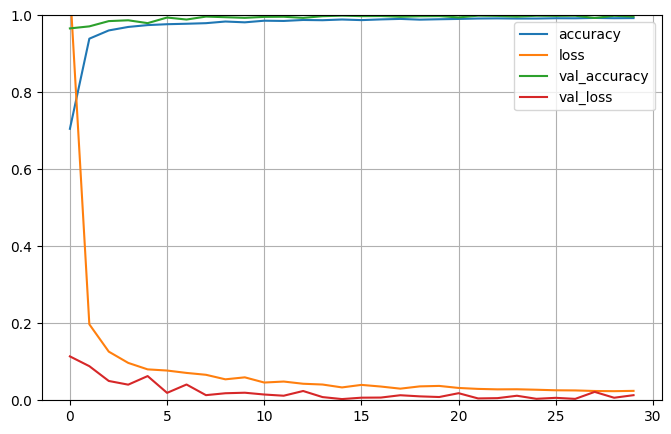

In [97]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Predict test data


In [98]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# Predict probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(labels, predicted_classes) * 100
print(f'Test Data Accuracy: {accuracy:.2f}%')

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Data Accuracy: 97.85%


#### Classification Report

In [99]:
from sklearn.metrics import classification_report

print(classification_report(labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        60
           1       0.99      1.00      1.00       720
           2       0.99      0.99      0.99       750
           3       0.99      0.95      0.97       450
           4       1.00      0.99      0.99       660
           5       0.96      0.99      0.98       630
           6       0.97      0.99      0.98       150
           7       1.00      0.98      0.99       450
           8       0.98      0.96      0.97       450
           9       0.99      0.99      0.99       480
          10       0.97      1.00      0.98       660
          11       0.91      1.00      0.95       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       0.96      1.00      0.98       270
          15       1.00      1.00      1.00       210
          16       0.99      1.00      1.00       150
          17       1.00    

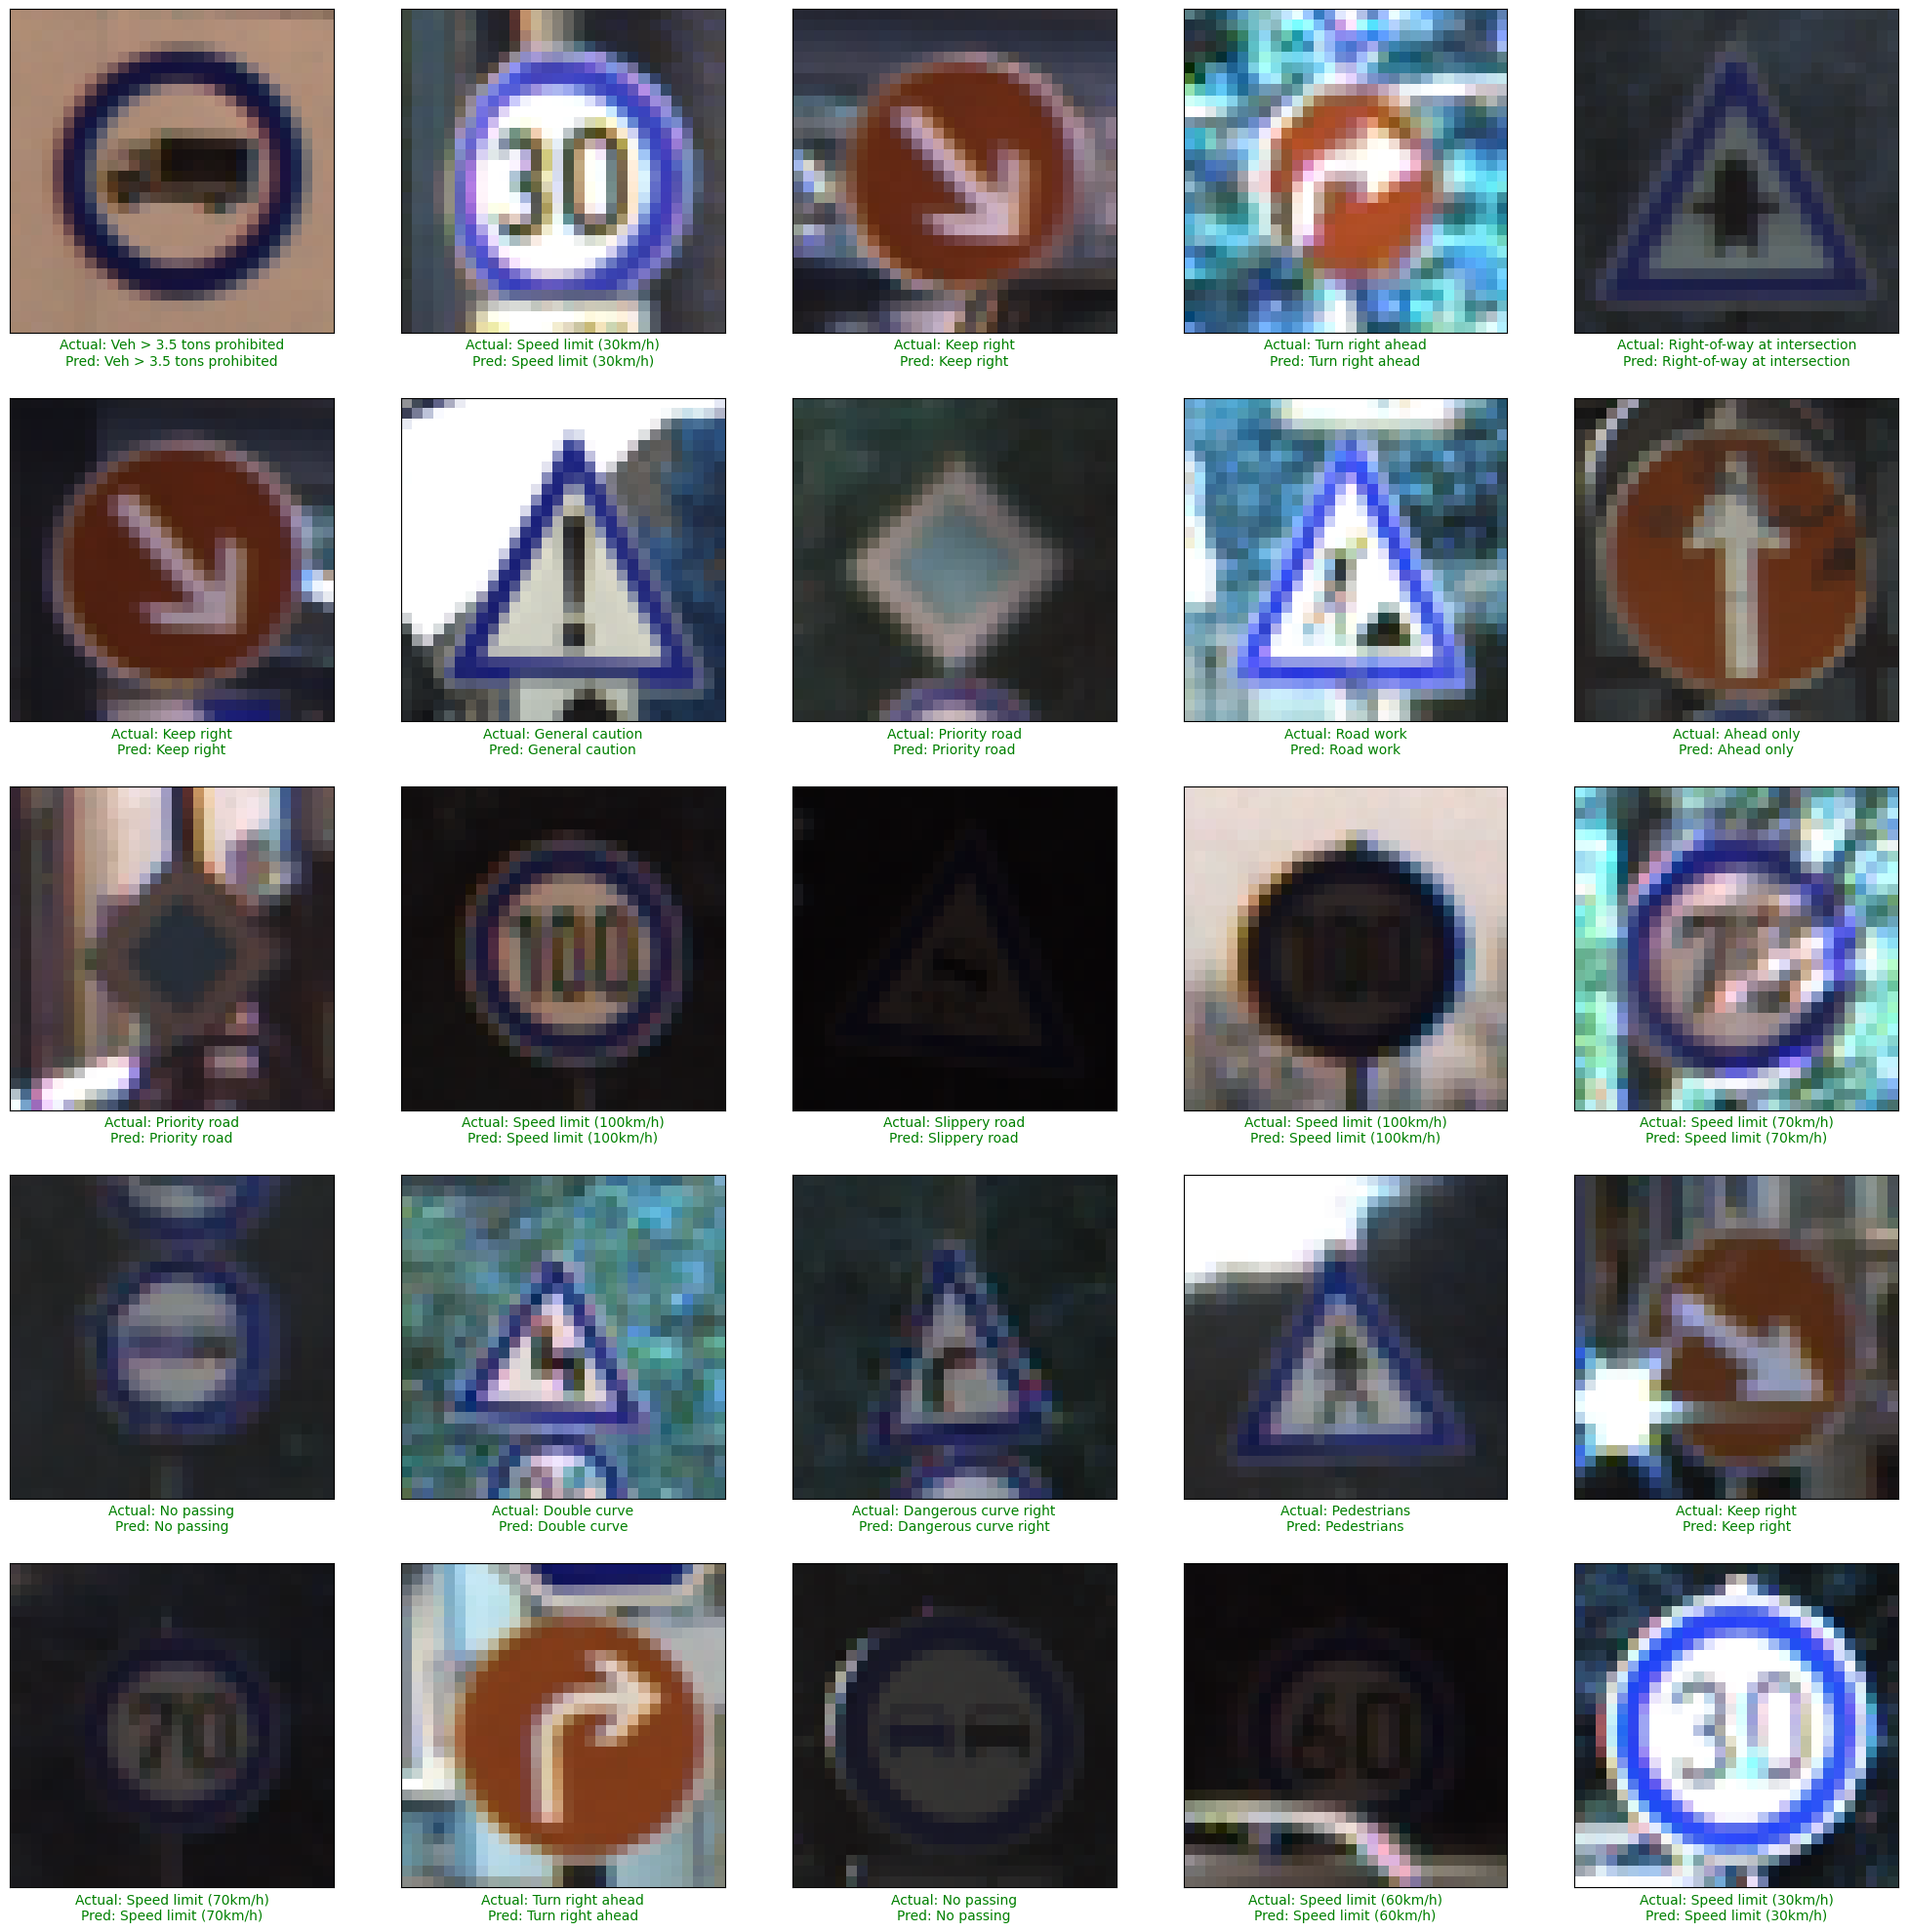

In [100]:
plt.figure(figsize=(25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Map predicted and actual classes to their descriptions
    prediction = predicted_classes[start_index + i]
    actual = labels[start_index + i]
    pred_label = classes[prediction]
    actual_label = classes[actual]
    
    # Set color for correct/incorrect predictions
    col = 'g' if prediction == actual else 'r'
    
    # Display the labels in the title
    plt.xlabel(f'Actual: {actual_label}\nPred: {pred_label}', color=col)
    plt.imshow(X_test[start_index + i])
plt.show()
